# Image Reconstruction of Neutral Hydrogen Intensity Mapping

This code reconstructs the images from the observations simulated via Karabo using an injected sky models. The injected sky model (HI simulation) used here is generated with Pinocchio and is half-sky, containing: right ascension, declination, observed redshift and flux. OSKAR (on which Karabo is based on) cannot handle continuous sources, so we pass the catalog from HI simulations via PINOCCHIO as point sources.

In [1]:
import matplotlib.pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
from astropy.coordinates import EarthLocation, AltAz, ICRS
import astropy.units as u
from pathlib import Path

from karabo.simulation.sky_model import SkyModel, SkyPrefixMapping
from karabo.simulation.line_emission import (
    line_emission_pointing,
    plot_scatter_recon,
    gaussian_fwhm_meerkat,
    simple_gaussian_beam_correction,
)

%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


We define the parameters which we will need for the simulation.

In [2]:
catalog_path = "data/point_sources_OSKAR1_diluted5000.h5"
outpath = Path("results")

cut = 3.0

The observation location should be compatible with the MeerKAT site. Also, the observation time and the coordinate has to be set. We need to pay attention that the sky model passes through the field of view during the observation! Therefore, we choose an observation time and calculate a corresponding possible phase center, which we choose to be the zenith at observation time.

In [3]:
# Observation specifications
# Observation location = MeerKAT location
MeerKAT_lon = "21d26m38.0s"  # Earth location
MeerKAT_lat = "-30d42m39.8s"  # deg. Corresponds to phase center dec.
meerkat_location = EarthLocation(
    lon=MeerKAT_lon, lat=MeerKAT_lat, height=1086.6 * u.m
)  # MeerKAT positon

# Specify an observation time -> take whatever you want
t_obs = "2000-03-20 12:06:39"  # 2022-09-01 09:09:00.
observing_time = Time(t_obs)

# We want to find the phase center which we define to be the zenith at the location of MeerKAT during the observation time
pointing = AltAz(
    alt=90 * u.deg, az=0 * u.deg, location=meerkat_location, obstime=observing_time
)
phase_center = pointing.transform_to(ICRS())
print("The phase center is at:", phase_center)

ra_deg = phase_center.ra.deg
dec_deg = phase_center.dec.deg
print(datetime(2000, 3, 20, 12, 6, 39))

The phase center is at: <ICRS Coordinate: (ra, dec) in deg
    (21.44213503, -30.70729488)>
2000-03-20 12:06:39


We create the sky model. To do so we read in the catalog from the HI simulations. Then, we only take sources in account which are within a certain radius (in degrees), which corresponds to our chosen FOV.

In [4]:
# %%timeit
sky_pointing = SkyModel.sky_from_h5_with_redshift_filtered(
    catalog_path, ra_deg, dec_deg
)

The catalog keys are: ['Declination', 'Flux', 'Observed Redshift', 'Right Ascension']
The unit of the flux given here is: J/m²/s = 10^(26)*Jy*Hz
Number of elements in the complete catalog: 223930
Number of elements in diluted catalog in the interesting FOV: 1318


Scatter plot of the diluted sky model in the FOV.

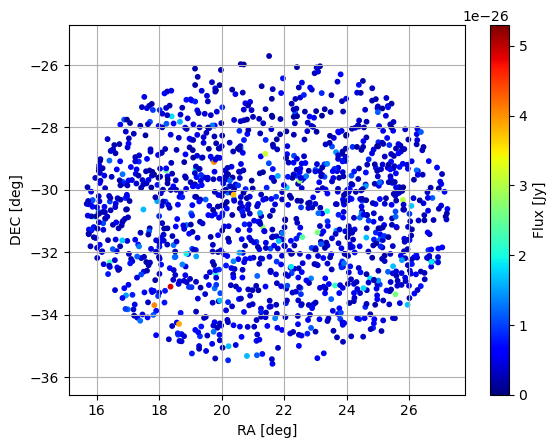

In [5]:
# We do a scatter plot with the function from karabo
sky_pointing.explore_sky(
    phase_center=(ra_deg, dec_deg),
    vmin=0,
    s=10,
    cmap="jet",
    cbar_label="Flux [Jy]",
    cfun=None,
    wcs_enabled=False,
    xlabel="RA [deg]",
    ylabel="DEC [deg]",
)

Depending on the number of frequency channels we would like to observe in we should have the edges of the channels. Here the assumption is that the channels are uniformly binned, so we use linspace function from the numpy library. But any type of binning is possible.

We recall that $1+z = \frac{\lambda_{obs}}{\lambda_{emit}}$, where the emitting wavelength of HI is 21 cm = 0.21m and $\lambda = \frac{c}{f}$. Therefore $f_{obs} = \frac{c}{0.21(1+z)}$.

We loop through the different redshift/frequency slices and reconstruct the respective redshift slice sky to simulate line emission. The output images are then saved according to their redshift slice. Additionally, all slices are added together and plotted.

The details for working with Karabo can be found here https://i4ds.github.io/Karabo-Pipeline/.

In [6]:
# Update some dask settings
from karabo.util.dask import DaskHandler

DaskHandler.n_threads_per_worker = 1  # Technically, this should be the same as number of cores. However, we run into memory problems otherwise. The higher the numbers, the more threads, the faster the computation but the more memory is needed.
# I am surprised that dask has such big problems with the memory usage in threads. Just halt one thread, spill it to the disk and finish the other calculations? I guess, this is not so easy to implement.

In [7]:
# %%timeit
dirty_im, _, header_dirty, freq_mid_dirty = line_emission_pointing(
    outpath=outpath, sky=sky_pointing
)

Dashboard link: http://127.0.0.1:8787/status
Smallest redshift: <xarray.DataArray 'array-ab709ffa7b6bf17507d377dc50e9c499' ()>
array(0.769394)
Largest redshift: <xarray.DataArray 'array-ab709ffa7b6bf17507d377dc50e9c499' ()>
array(1.030887)
The frequency channel starts at: 806820376.5432308 Hz
The bin size of the freq channel is: 11750085.933512092 Hz
Submitting 10 jobs to the cluster.


The RASCIL data directory is not available - continuing but any simulations will fail


Save summed dirty images as fits file
Save 3-dim reconstructed dirty images as h5


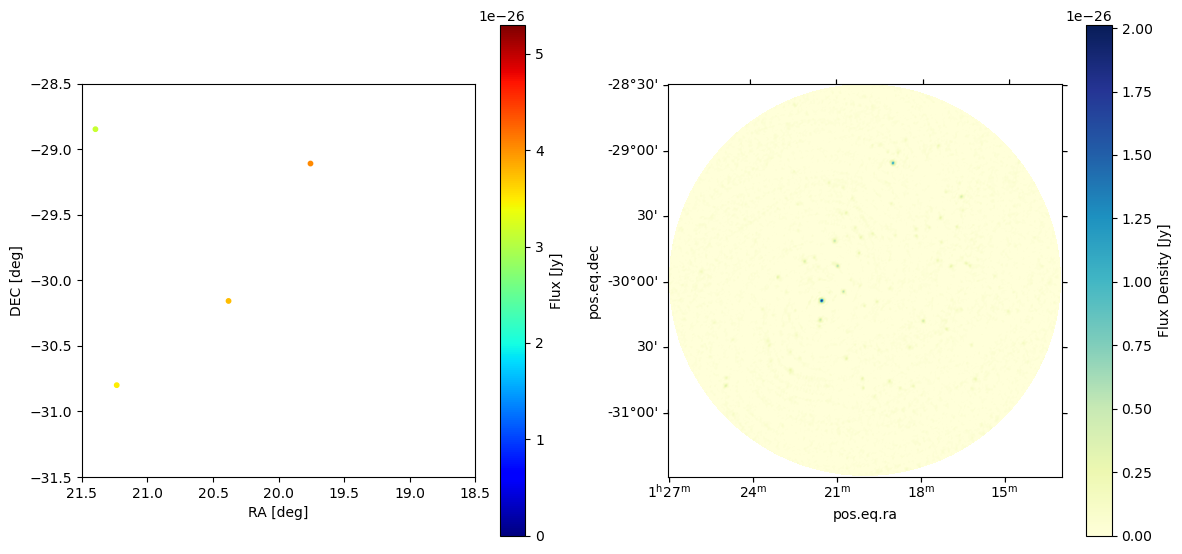

In [32]:
plot_scatter_recon(
    sky_pointing,
    dirty_im,
    outpath / "test_line_emission.pdf",
    header_dirty,
    f_min=3 * 10**-26,
    cut=3.0,
)

In a next step we correct for the primary beam. Here we assume that the primary beam is gaussian (what we also chose it to be in the simulation).


Calculate gaussian beam for primary beam correction...
Apply primary beam correction...


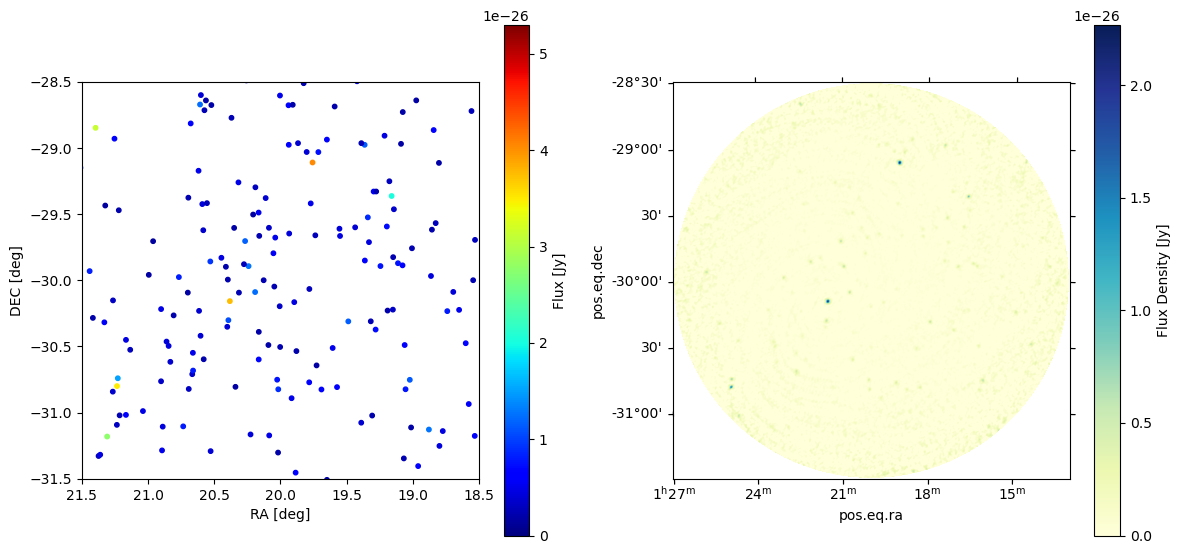

In [8]:
gauss_fwhm = gaussian_fwhm_meerkat(freq_mid_dirty)
beam_corrected, _ = simple_gaussian_beam_correction(outpath, dirty_im, gauss_fwhm)
plot_scatter_recon(
    sky_pointing,
    beam_corrected,
    outpath / "test_line_emission_beamcorrected.pdf",
    header_dirty,
    cut=3.0,
)

2
0
8


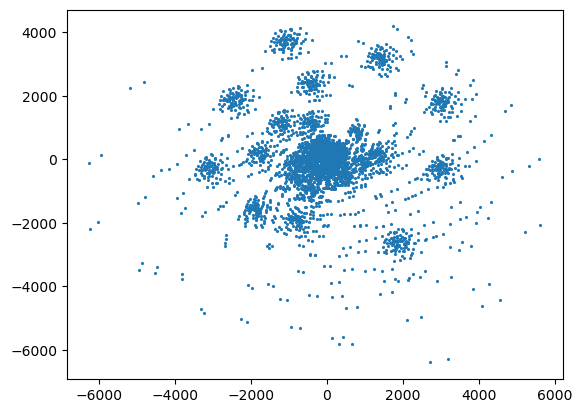

In [34]:
# The visbilities are already saved in vis files as chan_name+.vis and we can call them like this:
import oskar

(visHeader, visHandle) = oskar.VisHeader.read(str(outpath / "slice_0.vis"))
visBlock = oskar.VisBlock.create_from_header(visHeader)
print(visHeader.num_blocks)
for i in range(visHeader.num_blocks):
    visBlock.read(visHeader, visHandle, i)
    print(visBlock.start_time_index)
# vis = visBlock.cross_correlations()
uu = visBlock.baseline_uu_metres()
vv = visBlock.baseline_vv_metres()

plt.figure()
plt.scatter(uu, vv, s=2, marker="*")
plt.show()

# Investigate parallelization of the line emission simulation

In [35]:
from karabo.simulation.line_emission import run_one_channel_simulation, freq_channels
from dask import compute, delayed, visualize
from karabo.util.dask import DaskHandler

num_bins = 10
beam_type = "Gaussian beam"
gaussian_fwhm = 1.0
gaussian_ref_freq = 1.4639e9
start_time = datetime(2000, 3, 20, 12, 6, 39)
obs_length = timedelta(hours=3, minutes=5, seconds=0, milliseconds=0)
img_size = 4096
circle = True
rascil = True
verbose = False

sky_pointing.compute()

# Load observed redshifts
z_obs_pointing = sky_pointing.sources[:, 13]

In [36]:
redshift_channel, freq_channel, freq_bin, freq_mid = freq_channels(
    z_obs_pointing, num_bins
)

Smallest redshift: <xarray.DataArray 'array-282a5a7d8649b56f2ff71e8a2c600b69' ()>
array(0.769394)
Largest redshift: <xarray.DataArray 'array-282a5a7d8649b56f2ff71e8a2c600b69' ()>
array(1.030887)
The frequency channel starts at: 806820376.5432308 Hz
The bin size of the freq channel is: 11750085.933512092 Hz


In [37]:
run_simu_delayed = delayed(run_one_channel_simulation)
delayed_results = []
sky_pointing.sources = sky_pointing.sources
for bin_idx in range(num_bins):
    # Submit the jobs
    delayed_ = run_simu_delayed(
        outpath / (f"slice_{bin_idx}"),
        sky_pointing,
        bin_idx,
        redshift_channel[bin_idx],
        redshift_channel[bin_idx + 1],
        freq_channel[bin_idx],
        freq_bin,
        ra_deg,
        dec_deg,
        beam_type,
        gaussian_fwhm,
        gaussian_ref_freq,
        start_time,
        obs_length,
        cut,
        img_size,
        circle,
        rascil,
        verbose,
    )
    delayed_results.append(delayed_)

In [38]:
delayed_results

[Delayed('run_one_channel_simulation-94f05e19-834c-4ceb-8d80-77e0ab553dbe'),
 Delayed('run_one_channel_simulation-4bec28ab-4b41-4ae5-b573-7525b6ea679f'),
 Delayed('run_one_channel_simulation-27873015-955d-42b0-ac8f-7472b851fab7'),
 Delayed('run_one_channel_simulation-e6e86ce0-e691-4f3a-945c-c63c6678de7e'),
 Delayed('run_one_channel_simulation-56c73789-f1a0-44ce-94ae-825ba6d2ba80'),
 Delayed('run_one_channel_simulation-2df9203e-1d81-466f-bc87-2462560ec2fa'),
 Delayed('run_one_channel_simulation-63ff4c3c-50ac-4689-bca6-6013d5b8a1b4'),
 Delayed('run_one_channel_simulation-f66a75d1-59b9-442f-a256-6f54e27045d9'),
 Delayed('run_one_channel_simulation-7d222b6a-3cd8-4276-9dc8-08acca2825e9'),
 Delayed('run_one_channel_simulation-29a6a51b-dbf4-4cdb-945b-b61983b2c031')]

In [39]:
result = compute(*delayed_results, scheduler="distributed")
dirty_images = [x[0] for x in result]
# visualize(*delayed_results, rankdir="LR", optimize_graph=True, color="order")

In [40]:
import numpy as np

In [41]:
dirty_image = delayed(np.einsum)("ijk->jk", delayed_results)

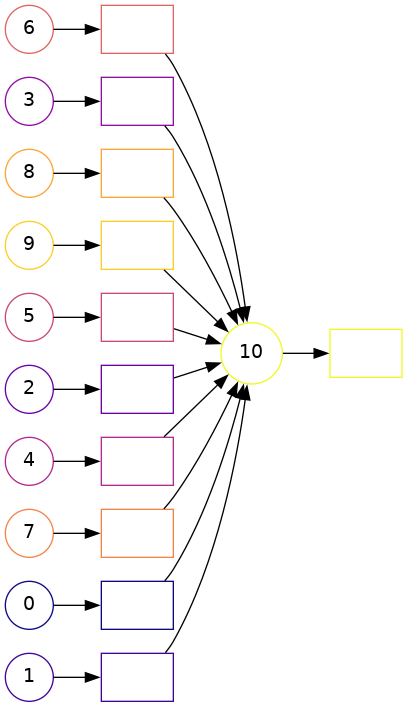

In [42]:
dirty_image.visualize(
    rankdir="LR", optimize_graph=True, color="order"
)  # , filename="dask_distribution_LE.pdf"